# ECOv003 JET Accuracy Analysis with ECOv002 Cal-Val - Calibration Comparison

This notebook compares the accuracy of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data **with and without calibration** applied to air temperature (Ta), relative humidity (RH), and soil moisture (SM).

The notebook shows side-by-side comparisons to demonstrate the impact of calibration on model accuracy.

## Overview

This notebook demonstrates the impact of calibration on JET ensemble model accuracy by:

1. **Processing data twice**: Once without calibration (baseline) and once with calibration applied to meteorological inputs (Ta, RH, SM)
2. **Creating side-by-side comparisons**: All figures show both uncalibrated (left) and calibrated (right) results
3. **Quantifying improvements**: R² and RMSE metrics are shown for both versions to measure calibration effectiveness

The calibration corrects systematic biases in:
- **Air Temperature (Ta_C)**: Temperature measurements from GEOS-5 FP
- **Relative Humidity (RH)**: Humidity measurements from GEOS-5 FP  
- **Soil Moisture (SM)**: Soil moisture measurements from SMAP

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the JET ensemble, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from JET3 import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

In [6]:
# Helper function to print detailed metric calculations
def print_metric_calculation(y_true, y_pred, metric_name="Model"):
    """
    Print step-by-step metric calculation with intermediate values and validation.
    """
    print(f"\n{'='*80}")
    print(f"Detailed Metric Calculation for {metric_name}")
    print(f"{'='*80}")
    
    # Data summary
    print(f"\nData Summary:")
    print(f"  Sample size (n): {len(y_true)}")
    print(f"  y_true (in-situ) - Min: {y_true.min():.4f}, Max: {y_true.max():.4f}, Mean: {y_true.mean():.4f}, Std: {y_true.std():.4f}")
    print(f"  y_pred (model)   - Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}, Mean: {y_pred.mean():.4f}, Std: {y_pred.std():.4f}")
    
    # R² Calculation
    print(f"\nR² (Coefficient of Determination) Calculation:")
    residuals = y_true - y_pred
    ss_res = (residuals ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"  Formula: R² = 1 - (SS_res / SS_tot)")
    print(f"  SS_res (sum of squared residuals) = Σ(y_true - y_pred)² = {ss_res:.4f}")
    print(f"  SS_tot (total sum of squares)     = Σ(y_true - mean(y_true))² = {ss_tot:.4f}")
    print(f"  R² = 1 - ({ss_res:.4f} / {ss_tot:.4f}) = {r2:.4f}")
    
    # Verify with sklearn
    r2_sklearn = r2_score(y_true, y_pred)
    print(f"  ✓ sklearn r2_score result: {r2_sklearn:.4f} (matches: {np.isclose(r2, r2_sklearn)})")
    
    # RMSE Calculation
    print(f"\nRMSE (Root Mean Squared Error) Calculation:")
    mse = (residuals ** 2).mean()
    rmse = np.sqrt(mse)
    
    print(f"  Formula: RMSE = √(MSE) = √(Σ(y_true - y_pred)² / n)")
    print(f"  MSE (mean squared error) = {mse:.4f}")
    print(f"  RMSE = √{mse:.4f} = {rmse:.4f}")
    
    # Verify with sklearn
    rmse_sklearn = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"  ✓ sklearn RMSE result: {rmse_sklearn:.4f} (matches: {np.isclose(rmse, rmse_sklearn)})")
    
    # MAE Calculation
    print(f"\nMAE (Mean Absolute Error) Calculation:")
    abs_residuals = np.abs(residuals)
    mae = abs_residuals.mean()
    
    print(f"  Formula: MAE = Σ|y_true - y_pred| / n")
    print(f"  Sum of absolute errors = {abs_residuals.sum():.4f}")
    print(f"  MAE = {abs_residuals.sum():.4f} / {len(y_true)} = {mae:.4f}")
    
    # Verify with sklearn
    mae_sklearn = mean_absolute_error(y_true, y_pred)
    print(f"  ✓ sklearn MAE result: {mae_sklearn:.4f} (matches: {np.isclose(mae, mae_sklearn)})")
    
    # Model performance interpretation
    print(f"\nModel Performance Interpretation:")
    if r2 > 0.7:
        print(f"  R² = {r2:.4f}: Excellent fit (explains {r2*100:.1f}% of variance)")
    elif r2 > 0.5:
        print(f"  R² = {r2:.4f}: Good fit (explains {r2*100:.1f}% of variance)")
    elif r2 > 0:
        print(f"  R² = {r2:.4f}: Moderate fit (explains {r2*100:.1f}% of variance)")
    elif r2 > -1:
        print(f"  R² = {r2:.4f}: Poor fit (worse than mean baseline by {-r2*100:.1f}%)")
    else:
        print(f"  R² = {r2:.4f}: Very poor fit")
    
    print(f"  RMSE = {rmse:.4f}: Average prediction error in same units as data")
    print(f"  MAE = {mae:.4f}: Mean magnitude of errors (robust to outliers)")
    print(f"{'='*80}\n")
    
    return r2, rmse, mae

# Helper function to print detailed correlation calculations
def print_correlation_calculation(x, y, x_name="X", y_name="Y"):
    """
    Print step-by-step correlation calculation with intermediate values and validation.
    """
    print(f"\nPearson Correlation Calculation: {x_name} vs {y_name}")
    
    # Data summary
    print(f"  Sample size (n): {len(x)}")
    print(f"  {x_name} - Min: {x.min():.4f}, Max: {x.max():.4f}, Mean: {x.mean():.4f}, Std: {x.std():.4f}")
    print(f"  {y_name} - Min: {y.min():.4f}, Max: {y.max():.4f}, Mean: {y.mean():.4f}, Std: {y.std():.4f}")
    
    # Calculate Pearson correlation using standard formula
    x_centered = x - x.mean()
    y_centered = y - y.mean()
    
    # Numerator: covariance * n (or sum of products of centered values)
    numerator = (x_centered * y_centered).sum()
    
    # Denominator: sqrt of sum of squared deviations for both
    x_sum_sq = (x_centered ** 2).sum()
    y_sum_sq = (y_centered ** 2).sum()
    denominator = np.sqrt(x_sum_sq * y_sum_sq)
    
    correlation = numerator / denominator if denominator != 0 else 0
    
    print(f"  Formula: r = Σ[(x - mean(x)) * (y - mean(y))] / √[Σ(x - mean(x))² * Σ(y - mean(y))²]")
    print(f"  Numerator: {numerator:.4f}")
    print(f"  X sum of squares: {x_sum_sq:.4f}")
    print(f"  Y sum of squares: {y_sum_sq:.4f}")
    print(f"  Denominator: √({x_sum_sq:.4f} * {y_sum_sq:.4f}) = {denominator:.4f}")
    print(f"  Correlation: {numerator:.4f} / {denominator:.4f} = {correlation:.4f}")
    
    # Verify with numpy
    corr_numpy = np.corrcoef(x, y)[0, 1]
    print(f"  ✓ numpy corrcoef result: {corr_numpy:.4f} (matches: {np.isclose(correlation, corr_numpy)})")
    
    # Interpretation
    if np.abs(correlation) >= 0.7:
        print(f"  Interpretation: Strong {'positive' if correlation > 0 else 'negative'} correlation")
    elif np.abs(correlation) >= 0.5:
        print(f"  Interpretation: Moderate {'positive' if correlation > 0 else 'negative'} correlation")
    elif np.abs(correlation) >= 0.3:
        print(f"  Interpretation: Weak {'positive' if correlation > 0 else 'negative'} correlation")
    else:
        print(f"  Interpretation: Very weak or negligible correlation")
    
    return correlation

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [7]:
input_df = load_ECOv002_calval_JET_inputs()

# Store in-situ ground truth values
input_df["insitu_RH"] = input_df["RH_percentage"]
input_df["insitu_SM"] = input_df["SM_surf"]
input_df["insitu_Ta_C"] = input_df["insitu_Ta_C"]

# Use in-situ RH as model input for cal-val analysis
# This shows what calibration does to the actual ground truth data
input_df["RH"] = input_df["RH_percentage"]

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/1175044870.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df["insitu_SM"] = input_df["SM_surf"]


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point,insitu_SM
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.302400
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.352800
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.389100
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.348350
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.258975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14,0.382250
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14,0.071600
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14,0.341000
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12,0.295767


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [8]:
# Process data WITHOUT calibration
print("Processing WITHOUT calibration...")
processed_uncalibrated = forward_process(input_df, use_calibration=False)
processed_uncalibrated

# Process data WITH calibration  
print("\nProcessing WITH calibration...")
processed_calibrated = forward_process(input_df, use_calibration=True)
processed_calibrated

Processing WITHOUT calibration...
[2026-02-27 13:50:22 INFO] starting JET table processing
[2026-02-27 13:50:22 INFO] started extracting geometry from JET input table
[2026-02-27 13:50:22 INFO] completed extracting geometry from JET input table (0.004 seconds)
[2026-02-27 13:50:22 INFO] started extracting time from JET input table
[2026-02-27 13:50:22 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-02-27 13:50:22 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-02-27 13:50:22 INFO] completed processing FLiES-ANN in 0.15 seconds
[2026-02-27 13:50:22 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-02-27 13:50:22 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-02-27 13:50:22 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-02-27 13:50:22 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605

/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/BESS_JPL/meteorology.py:394: RuntimeWarning: invalid value encountered in sqrt
  epsa0 = 0.605 + 0.048 * (Ea_Pa / 100) ** 0.5  # Clear-sky emissivity
/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: divide by zero encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]
/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:76: RuntimeWarning: divide by zero encountered in divide
  rs = 1.0 / (gs1 / cf * 1e-2)  # [s m-1]
/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: invalid value encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]


[2026-02-27 13:50:23 INFO] variable LE_canopy_Wm2 min: -0.466 mean: 79.555 max: 442.648 nan: 0.00% (nan)
[2026-02-27 13:50:23 INFO] variable RBL_max (float32) with [ 45.  50.  55.  95. 100.] unique values
[2026-02-27 13:50:23 INFO] * 45.0: 57
[2026-02-27 13:50:23 INFO] * 50.0: 132
[2026-02-27 13:50:23 INFO] * 55.0: 37
[2026-02-27 13:50:23 INFO] * 95.0: 28
[2026-02-27 13:50:23 INFO] * 100.0: 16
[2026-02-27 13:50:23 INFO] variable RBL_min (float32) with [20. 25. 65.] unique values
[2026-02-27 13:50:23 INFO] * 20.0: 169
[2026-02-27 13:50:23 INFO] * 25.0: 57
[2026-02-27 13:50:23 INFO] * 65.0: 44
[2026-02-27 13:50:23 INFO] variable rtotc min: 20.000 mean: 42.686 max: 98.769 nan: 0.00% (nan)
[2026-02-27 13:50:23 INFO] variable rtot min: 22.116 mean: 49.168 max: 127.482 nan: 0.00% (nan)
[2026-02-27 13:50:23 INFO] variable rrs min: 171.437 mean: 245.386 max: 334.206 nan: 0.00% (nan)
[2026-02-27 13:50:23 INFO] variable ras min: 20.015 mean: 40.003 max: 92.114 nan: 0.00% (nan)
[2026-02-27 13:50:

/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/PMJPL/soil_moisture_constraint.py:19: RuntimeWarning: invalid value encountered in power
  return RH ** (VPD / beta)


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,2.892237,23.104762,23.104762,199.664310,2.841699,1.204232,0.000151,0.000100,1.505782,
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,2.895111,13.746445,13.746445,206.181713,3.525059,1.042839,0.000108,0.000075,1.441796,
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,4.056927,33.009278,33.009278,374.099052,4.850926,1.203235,0.000291,0.000174,1.671006,
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,3.377600,41.179888,41.179888,319.033250,3.916425,1.723760,0.000294,0.000212,1.383956,
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,3.179742,3.072692,3.072692,119.215568,3.161127,0.577291,0.000095,0.000000,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,3.301652,29.420961,29.420961,367.167390,3.362586,0.819481,0.000233,0.000129,1.797606,
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,3.121629,21.369608,21.369608,278.657755,2.814532,1.041175,0.000138,0.000099,1.393810,
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.516552,74.858251,74.858251,51.071612,0.615429,1.464986,0.000053,0.000029,1.817717,
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.642150,64.471181,64.471181,103.372375,1.219605,1.405515,0.000048,0.000034,1.428551,


In [9]:
insitu_Ta_C = input_df["insitu_Ta_C"]
insitu_Ta_C

15      20.250940
17      12.665660
18      22.132050
19      28.275867
20      12.254800
          ...    
992     14.787343
994     11.983100
1001    11.620000
1020    21.662700
1021    21.688300
Name: insitu_Ta_C, Length: 270, dtype: float64

In-Situ Air Temperature Distribution:
Count:  270
Mean:   21.06°C
Median: 21.68°C
Std:    7.09°C
Min:    -0.49°C
Max:    35.14°C
25th percentile: 15.20°C
75th percentile: 26.19°C


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/207270861.py:32: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax2.boxplot(insitu_Ta_C, vert=True, patch_artist=True,


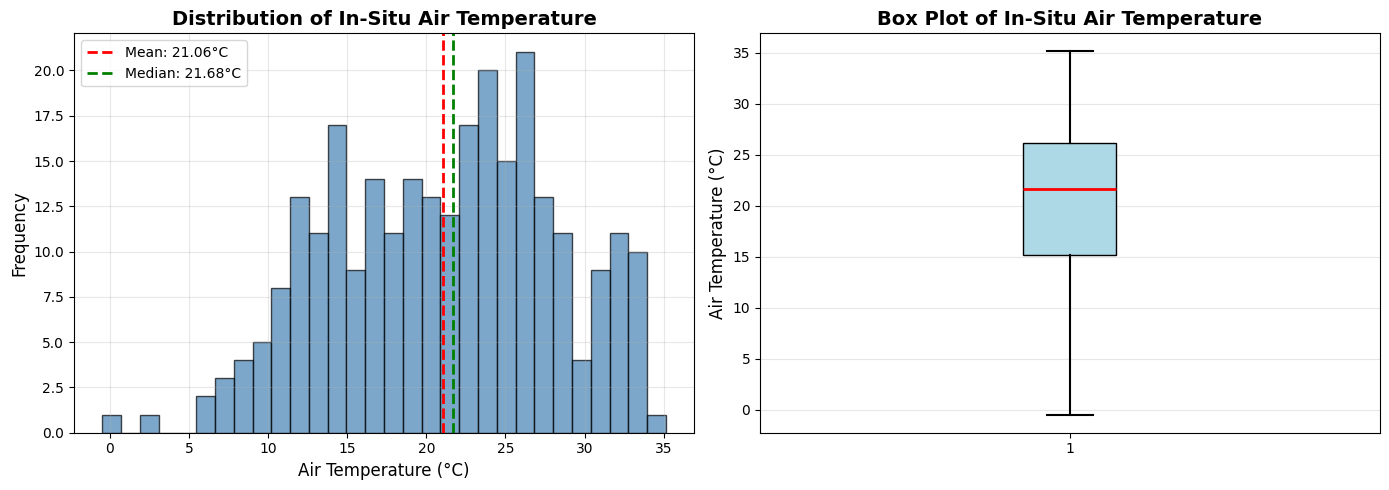

In [10]:
import numpy as np

import matplotlib.pyplot as plt

# Print statistics about insitu_Ta_C distribution
print("In-Situ Air Temperature Distribution:")
print("=" * 80)
print(f"Count:  {len(insitu_Ta_C)}")
print(f"Mean:   {insitu_Ta_C.mean():.2f}°C")
print(f"Median: {insitu_Ta_C.median():.2f}°C")
print(f"Std:    {insitu_Ta_C.std():.2f}°C")
print(f"Min:    {insitu_Ta_C.min():.2f}°C")
print(f"Max:    {insitu_Ta_C.max():.2f}°C")
print(f"25th percentile: {insitu_Ta_C.quantile(0.25):.2f}°C")
print(f"75th percentile: {insitu_Ta_C.quantile(0.75):.2f}°C")
print("=" * 80)

# Create figure with histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(insitu_Ta_C, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(insitu_Ta_C.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {insitu_Ta_C.mean():.2f}°C')
ax1.axvline(insitu_Ta_C.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {insitu_Ta_C.median():.2f}°C')
ax1.set_xlabel('Air Temperature (°C)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of In-Situ Air Temperature', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(insitu_Ta_C, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Air Temperature (°C)', fontsize=12)
ax2.set_title('Box Plot of In-Situ Air Temperature', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_Ta_Distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_Ta_Distribution.svg', format='svg', bbox_inches='tight')

plt.show()

In [11]:
uncalibrated_Ta_C = processed_uncalibrated['Ta_C']
uncalibrated_Ta_C

15      15.849697
17      14.842857
18      21.549250
19      26.457556
20      12.976667
          ...    
992     16.969240
994     14.792879
1001     9.609989
1020    22.611721
1021    23.101131
Name: Ta_C, Length: 270, dtype: float64

In [12]:
uncalibrated_Ta_C - insitu_Ta_C

15     -4.401243
17      2.177197
18     -0.582800
19     -1.818311
20      0.721867
          ...   
992     2.181897
994     2.809779
1001   -2.010011
1020    0.949021
1021    1.412831
Length: 270, dtype: float64

In [13]:
r2_score(insitu_Ta_C, uncalibrated_Ta_C)

0.8128338090406653

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/44134124.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax2.boxplot(uncalibrated_Ta_C, vert=True, patch_artist=True,


Uncalibrated Air Temperature Distribution:
Count:  270
Mean:   22.34°C
Median: 23.39°C
Std:    7.12°C
Min:    1.85°C
Max:    35.51°C
25th percentile: 16.73°C
75th percentile: 27.39°C


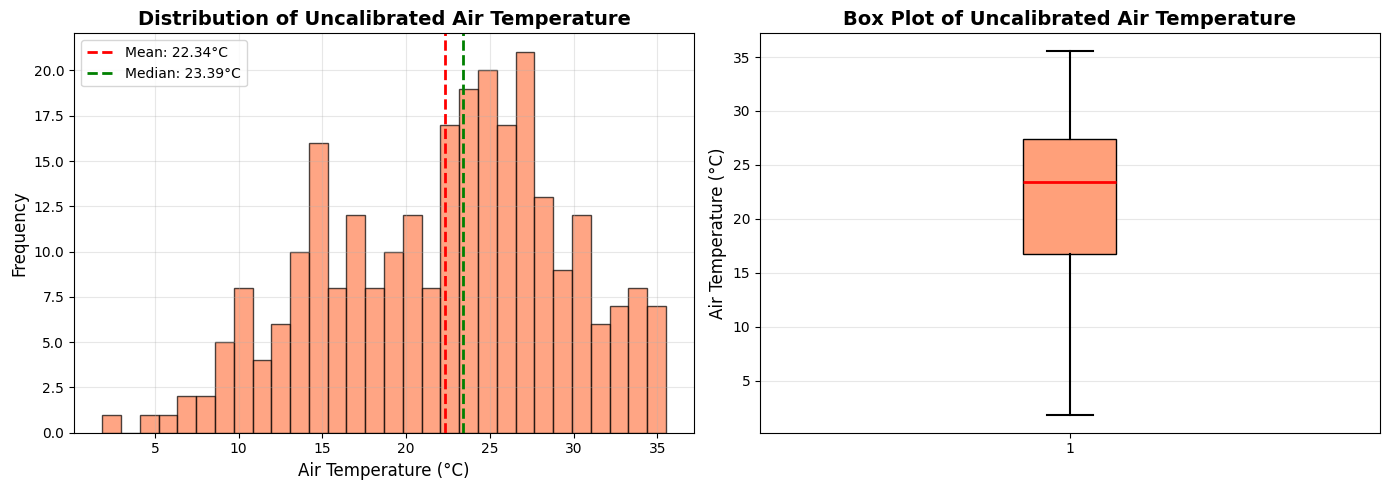

In [14]:
# Print statistics about uncalibrated_Ta_C distribution
print("Uncalibrated Air Temperature Distribution:")
print("=" * 80)
print(f"Count:  {len(uncalibrated_Ta_C)}")
print(f"Mean:   {uncalibrated_Ta_C.mean():.2f}°C")
print(f"Median: {uncalibrated_Ta_C.median():.2f}°C")
print(f"Std:    {uncalibrated_Ta_C.std():.2f}°C")
print(f"Min:    {uncalibrated_Ta_C.min():.2f}°C")
print(f"Max:    {uncalibrated_Ta_C.max():.2f}°C")
print(f"25th percentile: {uncalibrated_Ta_C.quantile(0.25):.2f}°C")
print(f"75th percentile: {uncalibrated_Ta_C.quantile(0.75):.2f}°C")
print("=" * 80)

# Create figure with histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(uncalibrated_Ta_C, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax1.axvline(uncalibrated_Ta_C.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {uncalibrated_Ta_C.mean():.2f}°C')
ax1.axvline(uncalibrated_Ta_C.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {uncalibrated_Ta_C.median():.2f}°C')
ax1.set_xlabel('Air Temperature (°C)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Uncalibrated Air Temperature', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(uncalibrated_Ta_C, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightsalmon', edgecolor='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Air Temperature (°C)', fontsize=12)
ax2.set_title('Box Plot of Uncalibrated Air Temperature', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Uncalibrated_Ta_Distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Uncalibrated_Ta_Distribution.svg', format='svg', bbox_inches='tight')

plt.show()

In [15]:
calibrated_Ta_C = processed_calibrated['Ta_C']
calibrated_Ta_C

15      16.000574
17      15.291515
18      20.491580
19      25.066005
20      13.470132
          ...    
992     15.707887
994     14.085697
1001    10.027418
1020    23.551345
1021    23.704526
Name: Ta_C, Length: 270, dtype: float64

Calibrated Air Temperature Distribution:
Count:  270
Mean:   21.16°C
Median: 22.32°C
Std:    6.90°C
Min:    0.94°C
Max:    36.23°C
25th percentile: 15.76°C
75th percentile: 25.71°C


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/2965834500.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax2.boxplot(calibrated_Ta_C, vert=True, patch_artist=True,


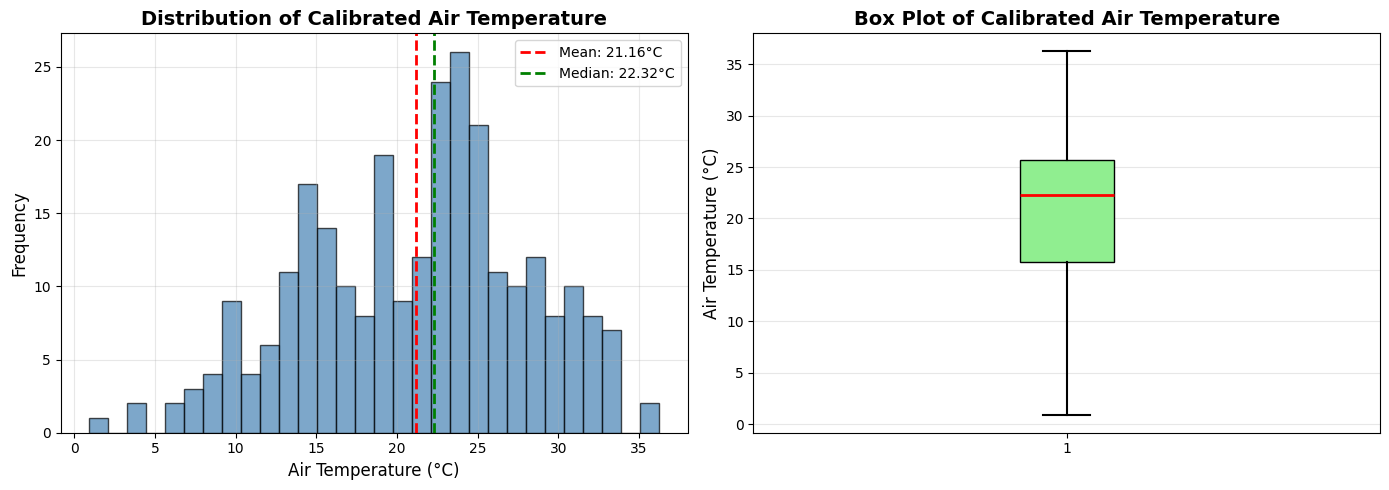

In [16]:
# Print statistics about calibrated_Ta_C distribution
print("Calibrated Air Temperature Distribution:")
print("=" * 80)
print(f"Count:  {len(calibrated_Ta_C)}")
print(f"Mean:   {calibrated_Ta_C.mean():.2f}°C")
print(f"Median: {calibrated_Ta_C.median():.2f}°C")
print(f"Std:    {calibrated_Ta_C.std():.2f}°C")
print(f"Min:    {calibrated_Ta_C.min():.2f}°C")
print(f"Max:    {calibrated_Ta_C.max():.2f}°C")
print(f"25th percentile: {calibrated_Ta_C.quantile(0.25):.2f}°C")
print(f"75th percentile: {calibrated_Ta_C.quantile(0.75):.2f}°C")
print("=" * 80)

# Create figure with histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(calibrated_Ta_C, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(calibrated_Ta_C.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {calibrated_Ta_C.mean():.2f}°C')
ax1.axvline(calibrated_Ta_C.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {calibrated_Ta_C.median():.2f}°C')
ax1.set_xlabel('Air Temperature (°C)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Calibrated Air Temperature', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(calibrated_Ta_C, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Air Temperature (°C)', fontsize=12)
ax2.set_title('Box Plot of Calibrated Air Temperature', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Calibrated_Ta_Distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Calibrated_Ta_Distribution.svg', format='svg', bbox_inches='tight')

plt.show()

In [17]:
# Create a table comparing in-situ, uncalibrated, and calibrated air temperature (Ta)
Ta_C_df = pd.DataFrame({
    'In-Situ Ta (°C)': insitu_Ta_C,
    'Uncalibrated Ta (°C)': uncalibrated_Ta_C,
    'Calibrated Ta (°C)': calibrated_Ta_C,
    'Uncalibrated Error (°C)': uncalibrated_Ta_C - insitu_Ta_C,
    'Calibrated Error (°C)': calibrated_Ta_C - insitu_Ta_C
})

# Calculate summary statistics
print("\nAir Temperature Comparison Summary Statistics:")
print("="*80)
print(f"\nIn-Situ Ta:")
print(f"  Mean: {Ta_C_df['In-Situ Ta (°C)'].mean():.2f}°C")
print(f"  Std:  {Ta_C_df['In-Situ Ta (°C)'].std():.2f}°C")
print(f"  Min:  {Ta_C_df['In-Situ Ta (°C)'].min():.2f}°C")
print(f"  Max:  {Ta_C_df['In-Situ Ta (°C)'].max():.2f}°C")

print(f"\nUncalibrated Ta:")
print(f"  Mean: {Ta_C_df['Uncalibrated Ta (°C)'].mean():.2f}°C")
print(f"  Std:  {Ta_C_df['Uncalibrated Ta (°C)'].std():.2f}°C")
print(f"  RMSE: {np.sqrt(mean_squared_error(Ta_C_df['In-Situ Ta (°C)'], Ta_C_df['Uncalibrated Ta (°C)'])):.2f}°C")
print(f"  MAE:  {mean_absolute_error(Ta_C_df['In-Situ Ta (°C)'], Ta_C_df['Uncalibrated Ta (°C)']):.2f}°C")

print(f"\nCalibrated Ta:")
print(f"  Mean: {Ta_C_df['Calibrated Ta (°C)'].mean():.2f}°C")
print(f"  Std:  {Ta_C_df['Calibrated Ta (°C)'].std():.2f}°C")
print(f"  RMSE: {np.sqrt(mean_squared_error(Ta_C_df['In-Situ Ta (°C)'], Ta_C_df['Calibrated Ta (°C)'])):.2f}°C")
print(f"  MAE:  {mean_absolute_error(Ta_C_df['In-Situ Ta (°C)'], Ta_C_df['Calibrated Ta (°C)']):.2f}°C")

print(f"\nError Statistics:")
print(f"  Uncalibrated Mean Error: {Ta_C_df['Uncalibrated Error (°C)'].mean():.2f}°C")
print(f"  Calibrated Mean Error:   {Ta_C_df['Calibrated Error (°C)'].mean():.2f}°C")
print(f"  Error Reduction:         {Ta_C_df['Uncalibrated Error (°C)'].abs().mean() - Ta_C_df['Calibrated Error (°C)'].abs().mean():.2f}°C")
print("="*80)

# Display the table
Ta_C_df


Air Temperature Comparison Summary Statistics:

In-Situ Ta:
  Mean: 21.06°C
  Std:  7.09°C
  Min:  -0.49°C
  Max:  35.14°C

Uncalibrated Ta:
  Mean: 22.34°C
  Std:  7.12°C
  RMSE: 3.06°C
  MAE:  2.22°C

Calibrated Ta:
  Mean: 21.16°C
  Std:  6.90°C
  RMSE: 2.08°C
  MAE:  1.54°C

Error Statistics:
  Uncalibrated Mean Error: 1.28°C
  Calibrated Mean Error:   0.09°C
  Error Reduction:         0.67°C


,In-Situ Ta (°C),Uncalibrated Ta (°C),Calibrated Ta (°C),Uncalibrated Error (°C),Calibrated Error (°C)
15,20.250940,15.849697,16.000574,-4.401243,-4.250366
17,12.665660,14.842857,15.291515,2.177197,2.625855
18,22.132050,21.549250,20.491580,-0.582800,-1.640470
19,28.275867,26.457556,25.066005,-1.818311,-3.209861
20,12.254800,12.976667,13.470132,0.721867,1.215332
...,...,...,...,...,...
992,14.787343,16.969240,15.707887,2.181897,0.920544
994,11.983100,14.792879,14.085697,2.809779,2.102597
1001,11.620000,9.609989,10.027418,-2.010011,-1.592582
1020,21.662700,22.611721,23.551345,0.949021,1.888645


Air temperature data points: 270

Air Temperature Comparison Metrics:

Detailed Metric Calculation for Air Temperature Uncalibrated

Data Summary:
  Sample size (n): 270
  y_true (in-situ) - Min: -0.4910, Max: 35.1400, Mean: 21.0640, Std: 7.0943
  y_pred (model)   - Min: 1.8530, Max: 35.5120, Mean: 22.3427, Std: 7.1162

R² (Coefficient of Determination) Calculation:
  Formula: R² = 1 - (SS_res / SS_tot)
  SS_res (sum of squared residuals) = Σ(y_true - y_pred)² = 2533.9679
  SS_tot (total sum of squares)     = Σ(y_true - mean(y_true))² = 13538.5985
  R² = 1 - (2533.9679 / 13538.5985) = 0.8128
  ✓ sklearn r2_score result: 0.8128 (matches: True)

RMSE (Root Mean Squared Error) Calculation:
  Formula: RMSE = √(MSE) = √(Σ(y_true - y_pred)² / n)
  MSE (mean squared error) = 9.3851
  RMSE = √9.3851 = 3.0635
  ✓ sklearn RMSE result: 3.0635 (matches: True)

MAE (Mean Absolute Error) Calculation:
  Formula: MAE = Σ|y_true - y_pred| / n
  Sum of absolute errors = 598.5840
  MAE = 598.5840 / 270 =

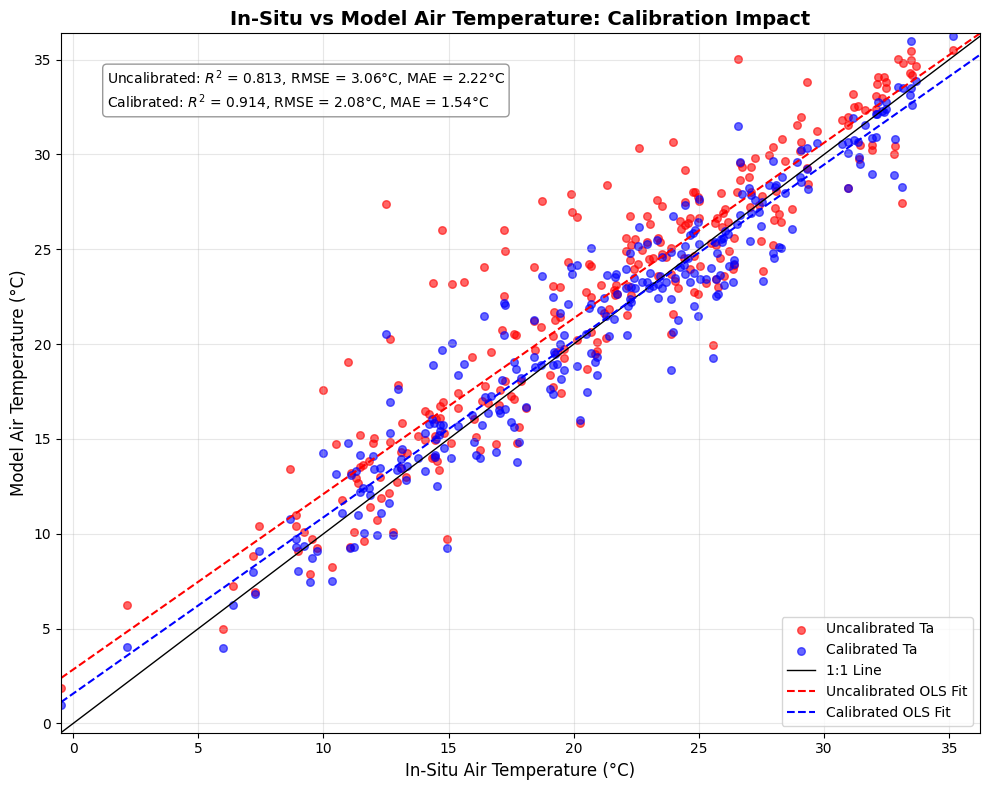

In [18]:
# Scatter plot: In-Situ Ta vs Uncalibrated/Calibrated Ta
fig, ax = plt.subplots(figsize=(10, 8))

# Get air temperature data
insitu_ta = Ta_C_df['In-Situ Ta (°C)']
uncal_ta = Ta_C_df['Uncalibrated Ta (°C)']
cal_ta = Ta_C_df['Calibrated Ta (°C)']

print(f"Air temperature data points: {len(insitu_ta)}")

# Scatter plots
ax.scatter(insitu_ta, uncal_ta, c='red', s=30, alpha=0.6, label='Uncalibrated Ta')
ax.scatter(insitu_ta, cal_ta, c='blue', s=30, alpha=0.6, label='Calibrated Ta')

# 1:1 line
min_val = min(insitu_ta.min(), uncal_ta.min(), cal_ta.min())
max_val = max(insitu_ta.max(), uncal_ta.max(), cal_ta.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_ta, uncal_ta, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_ta, cal_ta, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE
print("\nAir Temperature Comparison Metrics:")
r2_uncal_ta, rmse_uncal_ta, mae_uncal_ta = print_metric_calculation(insitu_ta, uncal_ta, "Air Temperature Uncalibrated")
r2_cal_ta, rmse_cal_ta, mae_cal_ta = print_metric_calculation(insitu_ta, cal_ta, "Air Temperature Calibrated")

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal_ta:.3f}, RMSE = {rmse_uncal_ta:.2f}°C, MAE = {mae_uncal_ta:.2f}°C\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal_ta:.3f}, RMSE = {rmse_cal_ta:.2f}°C, MAE = {mae_cal_ta:.2f}°C"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('In-Situ Air Temperature (°C)', fontsize=12)
ax.set_ylabel('Model Air Temperature (°C)', fontsize=12)
ax.set_title('In-Situ vs Model Air Temperature: Calibration Impact', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.autoscale(tight=True)

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_vs_Model_Air_Temperature.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_vs_Model_Air_Temperature.svg', format='svg', bbox_inches='tight')

plt.show()

In [19]:
insitu_RH = input_df["insitu_RH"]
insitu_RH

15      0.183300
17      0.501800
18      0.441600
19      0.315300
20      0.993600
          ...   
992     0.518000
994     0.416000
1001    0.226200
1020    0.176313
1021    0.222620
Name: insitu_RH, Length: 270, dtype: float64

In-Situ Relative Humidity Distribution:
Count:  270
Mean:   0.2657
Median: 0.2244
Std:    0.1683
Min:    0.0271
Max:    0.9936
25th percentile: 0.1379
75th percentile: 0.3633


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/1699359875.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax2.boxplot(insitu_RH, vert=True, patch_artist=True,


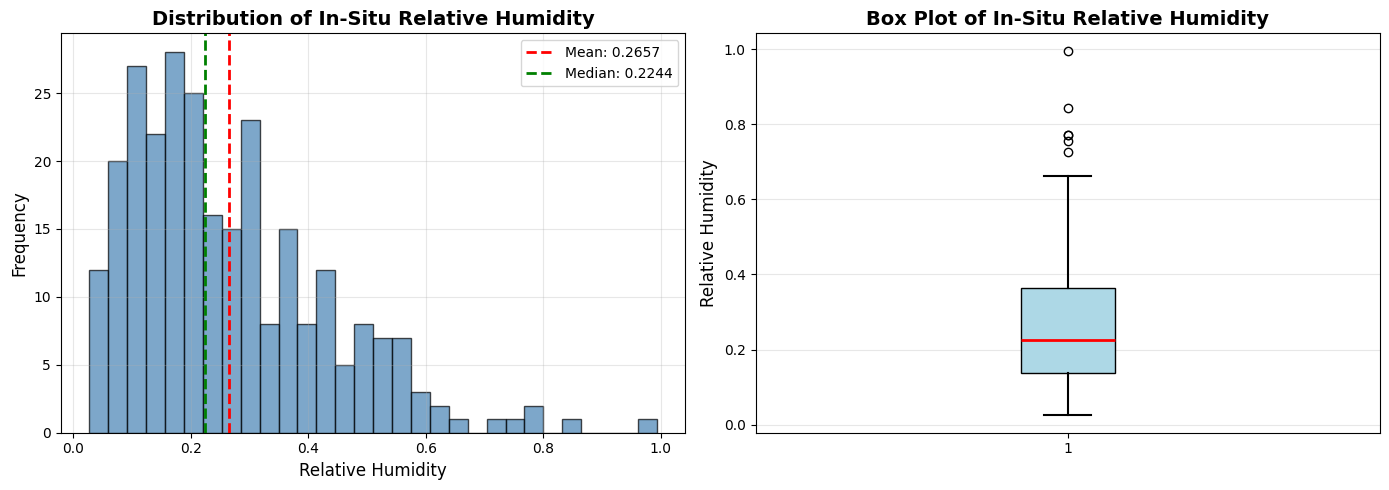

In [20]:
# Print statistics about insitu_RH distribution
print("In-Situ Relative Humidity Distribution:")
print("=" * 80)
print(f"Count:  {len(insitu_RH)}")
print(f"Mean:   {insitu_RH.mean():.4f}")
print(f"Median: {insitu_RH.median():.4f}")
print(f"Std:    {insitu_RH.std():.4f}")
print(f"Min:    {insitu_RH.min():.4f}")
print(f"Max:    {insitu_RH.max():.4f}")
print(f"25th percentile: {insitu_RH.quantile(0.25):.4f}")
print(f"75th percentile: {insitu_RH.quantile(0.75):.4f}")
print("=" * 80)

# Create figure with histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(insitu_RH, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(insitu_RH.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {insitu_RH.mean():.4f}')
ax1.axvline(insitu_RH.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {insitu_RH.median():.4f}')
ax1.set_xlabel('Relative Humidity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of In-Situ Relative Humidity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(insitu_RH, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Relative Humidity', fontsize=12)
ax2.set_title('Box Plot of In-Situ Relative Humidity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_RH_Distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_RH_Distribution.svg', format='svg', bbox_inches='tight')

plt.show()

In [21]:
uncalibrated_RH = processed_uncalibrated['RH']
uncalibrated_RH

15      0.183300
17      0.501800
18      0.441600
19      0.315300
20      0.993600
          ...   
992     0.518000
994     0.416000
1001    0.226200
1020    0.176313
1021    0.222620
Name: RH, Length: 270, dtype: float64

Uncalibrated Relative Humidity Distribution:
Count:  270
Mean:   0.2657
Median: 0.2244
Std:    0.1683
Min:    0.0271
Max:    0.9936
25th percentile: 0.1379
75th percentile: 0.3633


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_32391/130900420.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax2.boxplot(uncalibrated_RH, vert=True, patch_artist=True,


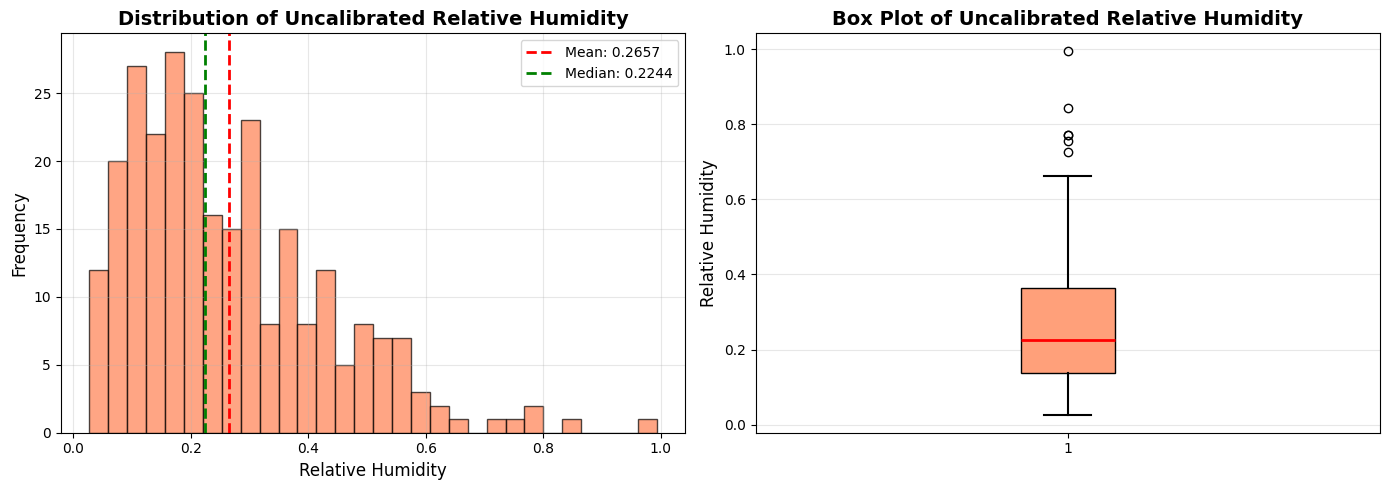

In [22]:
# Print statistics about uncalibrated_RH distribution
print("Uncalibrated Relative Humidity Distribution:")
print("=" * 80)
print(f"Count:  {len(uncalibrated_RH)}")
print(f"Mean:   {uncalibrated_RH.mean():.4f}")
print(f"Median: {uncalibrated_RH.median():.4f}")
print(f"Std:    {uncalibrated_RH.std():.4f}")
print(f"Min:    {uncalibrated_RH.min():.4f}")
print(f"Max:    {uncalibrated_RH.max():.4f}")
print(f"25th percentile: {uncalibrated_RH.quantile(0.25):.4f}")
print(f"75th percentile: {uncalibrated_RH.quantile(0.75):.4f}")
print("=" * 80)

# Create figure with histogram and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(uncalibrated_RH, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax1.axvline(uncalibrated_RH.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {uncalibrated_RH.mean():.4f}')
ax1.axvline(uncalibrated_RH.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {uncalibrated_RH.median():.4f}')
ax1.set_xlabel('Relative Humidity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Uncalibrated Relative Humidity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(uncalibrated_RH, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightsalmon', edgecolor='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Relative Humidity', fontsize=12)
ax2.set_title('Box Plot of Uncalibrated Relative Humidity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Uncalibrated_RH_Distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Uncalibrated_RH_Distribution.svg', format='svg', bbox_inches='tight')

plt.show()

In [23]:
uncalibrated_RH - insitu_RH

15      0.0
17      0.0
18      0.0
19      0.0
20      0.0
       ... 
992     0.0
994     0.0
1001    0.0
1020    0.0
1021    0.0
Length: 270, dtype: float64

In [24]:
r2_score(insitu_RH, uncalibrated_RH)

1.0

In [25]:
insitu_rh_clean, uncal_rh_clean = remove_outliers_iqr(insitu_RH, uncalibrated_RH)
uncal_rh_clean

NameError: name 'remove_outliers_iqr' is not defined

In [ ]:
# Print accuracy metrics for uncalibrated_RH vs insitu_RH
print("\n" + "="*80)
print("Accuracy Metrics: Uncalibrated RH vs In-Situ RH")
print("="*80)

print(f"\nData points: {len(uncalibrated_RH)}")

# Calculate detailed metrics
r2, rmse, mae = print_metric_calculation(
    insitu_RH, 
    uncalibrated_RH, 
    "Uncalibrated RH vs In-Situ RH"
)

# Summary
print(f"\n{'='*80}")
print("SUMMARY: Uncalibrated RH Accuracy Metrics")
print(f"{'='*80}")
print(f"R² Score:  {r2:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"{'='*80}\n")


In [ ]:
calibrated_RH = processed_calibrated['RH']
calibrated_RH

In [ ]:
calibrated_RH - insitu_RH

In [ ]:
# Create a table comparing in-situ, uncalibrated, and calibrated relative humidity (RH)
RH_df = pd.DataFrame({
    'In-Situ RH': insitu_RH,
    'Uncalibrated RH': uncalibrated_RH,
    'Calibrated RH': calibrated_RH,
    'Uncalibrated Error': uncalibrated_RH - insitu_RH,
    'Calibrated Error': calibrated_RH - insitu_RH
})

# Calculate summary statistics
print("\nRelative Humidity Comparison Summary Statistics:")
print("="*80)
print(f"\nIn-Situ RH:")
print(f"  Mean: {RH_df['In-Situ RH'].mean():.4f}")
print(f"  Std:  {RH_df['In-Situ RH'].std():.4f}")
print(f"  Min:  {RH_df['In-Situ RH'].min():.4f}")
print(f"  Max:  {RH_df['In-Situ RH'].max():.4f}")

print(f"\nUncalibrated RH:")
print(f"  Mean: {RH_df['Uncalibrated RH'].mean():.4f}")
print(f"  Std:  {RH_df['Uncalibrated RH'].std():.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(RH_df['In-Situ RH'], RH_df['Uncalibrated RH'])):.4f}")
print(f"  MAE:  {mean_absolute_error(RH_df['In-Situ RH'], RH_df['Uncalibrated RH']):.4f}")

print(f"\nCalibrated RH:")
print(f"  Mean: {RH_df['Calibrated RH'].mean():.4f}")
print(f"  Std:  {RH_df['Calibrated RH'].std():.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(RH_df['In-Situ RH'], RH_df['Calibrated RH'])):.4f}")
print(f"  MAE:  {mean_absolute_error(RH_df['In-Situ RH'], RH_df['Calibrated RH']):.4f}")

print(f"\nError Statistics:")
print(f"  Uncalibrated Mean Error: {RH_df['Uncalibrated Error'].mean():.4f}")
print(f"  Calibrated Mean Error:   {RH_df['Calibrated Error'].mean():.4f}")
print(f"  Error Reduction:         {RH_df['Uncalibrated Error'].abs().mean() - RH_df['Calibrated Error'].abs().mean():.4f}")
print("="*80)

# Display the table
RH_df

In [ ]:
# Calculate R² for uncalibrated RH vs in-situ RH
insitu_rh = RH_df['In-Situ RH']
uncal_rh = RH_df['Uncalibrated RH']

# Calculate R² using the detailed metric calculation function
print("\nUncalibrated RH vs In-Situ RH:")
r2_uncal_rh_check, rmse_uncal_rh_check, mae_uncal_rh_check = print_metric_calculation(
    insitu_rh, 
    uncal_rh, 
    "Uncalibrated RH"
)

print(f"\nUncalibrated RH R² = {r2_uncal_rh_check:.4f}")

In [ ]:
# Scatter plot: In-Situ RH vs Uncalibrated/Calibrated RH
fig, ax = plt.subplots(figsize=(10, 8))

# Get relative humidity data
insitu_rh = RH_df['In-Situ RH']
uncal_rh = RH_df['Uncalibrated RH']
cal_rh = RH_df['Calibrated RH']

print(f"Relative humidity data points: {len(insitu_rh)}")

# Scatter plots
ax.scatter(insitu_rh, uncal_rh, c='red', s=30, alpha=0.6, label='Uncalibrated RH')
ax.scatter(insitu_rh, cal_rh, c='blue', s=30, alpha=0.6, label='Calibrated RH')

# 1:1 line
min_val = min(insitu_rh.min(), uncal_rh.min(), cal_rh.min())
max_val = max(insitu_rh.max(), uncal_rh.max(), cal_rh.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_rh, uncal_rh, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_rh, cal_rh, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE
print("\nRelative Humidity Comparison Metrics:")
r2_uncal_rh, rmse_uncal_rh, mae_uncal_rh = print_metric_calculation(insitu_rh, uncal_rh, "Relative Humidity Uncalibrated")
r2_cal_rh, rmse_cal_rh, mae_cal_rh = print_metric_calculation(insitu_rh, cal_rh, "Relative Humidity Calibrated")

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal_rh:.3f}, RMSE = {rmse_uncal_rh:.4f}, MAE = {mae_uncal_rh:.4f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal_rh:.3f}, RMSE = {rmse_cal_rh:.4f}, MAE = {mae_cal_rh:.4f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('In-Situ Relative Humidity', fontsize=12)
ax.set_ylabel('Model Relative Humidity', fontsize=12)
ax.set_title('In-Situ vs Model Relative Humidity: Calibration Impact', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.autoscale(tight=True)

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_vs_Model_Relative_Humidity.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_vs_Model_Relative_Humidity.svg', format='svg', bbox_inches='tight')

plt.show()

In [ ]:
# Meteorological variables: Ta, RH, SM
met_variables = {
    'Ta_C': {
        'insitu_var': 'insitu_Ta_C',
        'uncal_var': 'Ta_C',
        'cal_var': 'Ta_C',
        'xlabel': 'In-Situ Ta (°C)',
        'ylabel': 'Model Ta (°C)'
    },
    'RH': {
        'insitu_var': 'insitu_RH',
        'uncal_var': 'RH',
        'cal_var': 'RH',
        'xlabel': 'In-Situ RH',
        'ylabel': 'Model RH'
    },
    'SM': {
        'insitu_var': 'insitu_SM',
        'uncal_var': 'SM',
        'cal_var': 'SM',
        'xlabel': 'In-Situ SM (m³/m³)',
        'ylabel': 'Model SM (m³/m³)'
    }
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (var, info) in enumerate(met_variables.items()):
    ax = axes[idx]
    
    # Get variable names
    insitu_var = info['insitu_var']
    uncal_var = info['uncal_var']
    cal_var = info['cal_var']
    
    print(f"\nProcessing {var}...")
    print(f"  In-situ: processed_calibrated['{insitu_var}']")
    print(f"  Uncalibrated: processed_uncalibrated['{uncal_var}']")
    print(f"  Calibrated: processed_calibrated['{cal_var}']")
    
    # Get valid data for both calibrated and uncalibrated
    insitu_vals = processed_calibrated[insitu_var].dropna()
    uncal_vals = processed_uncalibrated.loc[insitu_vals.index, uncal_var]
    cal_vals = processed_calibrated.loc[insitu_vals.index, cal_var]
    
    # Remove any remaining NaN values
    valid_mask = uncal_vals.notna() & cal_vals.notna()
    insitu_vals = insitu_vals[valid_mask]
    uncal_vals = uncal_vals[valid_mask]
    cal_vals = cal_vals[valid_mask]
    
    print(f"  Data points: {len(insitu_vals)}")
    
    # In-situ (x) vs model values (y)
    ax.scatter(x=insitu_vals, y=uncal_vals, c='red', s=12, alpha=0.6, label='Uncalibrated')
    ax.scatter(x=insitu_vals, y=cal_vals, c='blue', s=12, alpha=0.6, label='Calibrated')
    
    # Calculate metrics against in-situ
    if len(insitu_vals) > 1:
        # Print detailed metric calculation for uncalibrated
        print(f"\n{var} - Uncalibrated Model Metrics:")
        r2_uncal, rmse_uncal, mae_uncal = print_metric_calculation(insitu_vals, uncal_vals, f"{var} Uncalibrated")
        
        # Print detailed metric calculation for calibrated
        print(f"\n{var} - Calibrated Model Metrics:")
        r2_cal, rmse_cal, mae_cal = print_metric_calculation(insitu_vals, cal_vals, f"{var} Calibrated")
        
        # 1:1 line
        min_val = min(insitu_vals.min(), uncal_vals.min(), cal_vals.min())
        max_val = max(insitu_vals.max(), uncal_vals.max(), cal_vals.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line', alpha=0.5)
        
        # Add statistics
        stats_text = f"Uncal: R² = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2e}\n"
        stats_text += f"Cal: R² = {r2_cal:.3f}, RMSE = {rmse_cal:.2e}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel(info['xlabel'], fontsize=11)
    ax.set_ylabel(info['ylabel'], fontsize=11)
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.autoscale(tight=True)

plt.suptitle('In-Situ vs Model: Meteorological Variables', fontsize=14, fontweight='bold')
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_vs_Model_Meteorological_Variables.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_vs_Model_Meteorological_Variables.svg', format='svg', bbox_inches='tight')

plt.show()

In [ ]:
# Scatter plots: Insitu ET and LE vs Calibrated/Uncalibrated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ===== LEFT PLOT: ET =====
insitu_et_var = 'insitu_ET_daylight_kg'
uncal_et_var = 'ET_daylight_kg'
cal_et_var = 'ET_daylight_kg'
print(f"ET variable mapping -> In-situ: processed_calibrated['{insitu_et_var}'] | Uncalibrated: processed_uncalibrated['{uncal_et_var}'] | Calibrated: processed_calibrated['{cal_et_var}']")

# Get valid data for both calibrated and uncalibrated ET
insitu_et = processed_calibrated[insitu_et_var].dropna()
uncal_et = processed_uncalibrated.loc[insitu_et.index, uncal_et_var]
cal_et = processed_calibrated.loc[insitu_et.index, cal_et_var]

# Remove any remaining NaN values
valid_mask = uncal_et.notna() & cal_et.notna()
insitu_et = insitu_et[valid_mask]
uncal_et = uncal_et[valid_mask]
cal_et = cal_et[valid_mask]

print(f"ET data points: {len(insitu_et)}")

# Scatter plots
ax1.scatter(insitu_et, uncal_et, c='red', s=30, alpha=0.6, label='Uncalibrated ET')
ax1.scatter(insitu_et, cal_et, c='blue', s=30, alpha=0.6, label='Calibrated ET')

# 1:1 line
min_val = min(insitu_et.min(), uncal_et.min(), cal_et.min())
max_val = max(insitu_et.max(), uncal_et.max(), cal_et.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_et, uncal_et, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax1.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_et, cal_et, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax1.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE: model predictions vs in-situ observations (outlier-free data)
print(f"\n{'='*80}")
print(f"ET (Evapotranspiration) Comparison")
print(f"{'='*80}")
print(f"\nUncalibrated ET Metrics:")
r2_uncal, rmse_uncal, mae_uncal = print_metric_calculation(insitu_et, uncal_et, "Ensemble ET Uncalibrated")

print(f"Calibrated ET Metrics:")
r2_cal, rmse_cal, mae_cal = print_metric_calculation(insitu_et, cal_et, "Ensemble ET Calibrated")

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
ax1.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax1.set_xlabel('In-Situ ET (mm/day)', fontsize=12)
ax1.set_ylabel('Model ET (mm/day)', fontsize=12)
ax1.set_title('In-Situ ET vs Calibrated/Uncalibrated ET', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.autoscale(tight=True)

# ===== RIGHT PLOT: LE =====
insitu_le_var = 'insitu_LE_Wm2'
uncal_le_var = 'LE_Wm2'
cal_le_var = 'LE_Wm2'
print(f"\nLE variable mapping -> In-situ: processed_calibrated['{insitu_le_var}'] | Uncalibrated: processed_uncalibrated['{uncal_le_var}'] | Calibrated: processed_calibrated['{cal_le_var}']")

# Get valid data for both calibrated and uncalibrated LE
insitu_le = processed_calibrated[insitu_le_var].dropna()
uncal_le = processed_uncalibrated.loc[insitu_le.index, uncal_le_var]
cal_le = processed_calibrated.loc[insitu_le.index, cal_le_var]

# Remove any remaining NaN values
valid_mask = uncal_le.notna() & cal_le.notna()
insitu_le = insitu_le[valid_mask]
uncal_le = uncal_le[valid_mask]
cal_le = cal_le[valid_mask]

# Remove outliers using IQR method
insitu_le, uncal_le, cal_le = remove_outliers_iqr(insitu_le, uncal_le, cal_le)
print(f"LE data points: {len(insitu_le)}")

# Scatter plots
ax2.scatter(insitu_le, uncal_le, c='red', s=30, alpha=0.6, label='Uncalibrated LE')
ax2.scatter(insitu_le, cal_le, c='blue', s=30, alpha=0.6, label='Calibrated LE')

# 1:1 line
min_val = min(insitu_le.min(), uncal_le.min(), cal_le.min())
max_val = max(insitu_le.max(), uncal_le.max(), cal_le.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_le, uncal_le, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax2.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_le, cal_le, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax2.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE: model predictions vs in-situ observations (outlier-free data)
print(f"\nUncalibrated LE Metrics:")
r2_uncal, rmse_uncal, mae_uncal = print_metric_calculation(insitu_le, uncal_le, "Ensemble LE Uncalibrated")

print(f"Calibrated LE Metrics:")
r2_cal, rmse_cal, mae_cal = print_metric_calculation(insitu_le, cal_le, "Ensemble LE Calibrated")

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
ax2.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax2.set_xlabel('In-Situ LE (W/m²)', fontsize=12)
ax2.set_ylabel('Model LE (W/m²)', fontsize=12)
ax2.set_title('In-Situ LE vs Calibrated/Uncalibrated LE', fontsize=14)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.autoscale(tight=True)

plt.suptitle('In-Situ vs Model: ET and LE Comparison (Outliers Removed)', fontsize=16, y=1.00)
plt.tight_layout()
plt.suptitle('In-Situ vs Model: ET and LE Comparison', fontsize=16, y=1.00)
if SAVE_PLOTS:
    plt.savefig('Insitu_ET_LE_vs_Calibrated_Uncalibrated.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_ET_LE_vs_Calibrated_Uncalibrated.svg', format='svg', bbox_inches='tight')

plt.show()

## Individual Model Comparisons: ET and LE

Side-by-side comparison of ET (left) and LE (right) for each individual model in the JET ensemble:
- **BESS-JPL**: Breathing Earth System Simulator
- **STIC-JPL**: Surface Temperature Initiated Closure
- **PT-JPL-SM**: Priestley-Taylor with Soil Moisture constraint
- **PM-JPL**: Penman-Monteith

For each model, ET is derived from LE using the latent heat of vaporization (λ ≈ 2.45 MJ/kg).

In [ ]:
# Individual model comparisons: ET and LE side by side for each model
# Models in JET ensemble: BESS, STIC, PT-JPL-SM, PM-JPL

models = [
    {"name": "BESS", "le_col": "LE_BESS_Wm2"},
    {"name": "STIC", "le_col": "LE_STIC_Wm2"},
    {"name": "PT-JPL-SM", "le_col": "LE_PTJPLSM_Wm2"},
    {"name": "PM-JPL", "le_col": "LE_PMJPL_Wm2"}
]

# Latent heat of vaporization (J/kg) at 20°C
lambda_v = 2.45e6  # J/kg

for model_info in models:
    model_name_str = model_info["name"]
    le_col = model_info["le_col"]
    
    print(f"\n{'='*80}")
    print(f"Processing {model_name_str} Model")
    print(f"{'='*80}")
    
    # Check if the LE column exists
    if le_col not in processed_calibrated.columns:
        print(f"Skipping {model_name_str}: {le_col} not found")
        continue
    
    # Print variable mappings for this model
    insitu_et_var = 'insitu_ET_daylight_kg'
    insitu_le_var = 'insitu_LE_Wm2'
    print(f"\nET variable mapping for {model_name_str}:")
    print(f"  In-situ: processed_calibrated['{insitu_et_var}']")
    print(f"  Uncalibrated: processed_uncalibrated['{le_col}'] (converted to ET)")
    print(f"  Calibrated: processed_calibrated['{le_col}'] (converted to ET)")
    print(f"\nLE variable mapping for {model_name_str}:")
    print(f"  In-situ: processed_calibrated['{insitu_le_var}']")
    print(f"  Uncalibrated: processed_uncalibrated['{le_col}']")
    print(f"  Calibrated: processed_calibrated['{le_col}']")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # ===== LEFT PLOT: ET (convert from LE) =====
    # Get valid data for both calibrated and uncalibrated ET
    insitu_et = processed_calibrated[insitu_et_var].dropna()
    
    # Convert LE (W/m²) to ET (kg/m²/day = mm/day)
    # LE [W/m²] = LE [J/s/m²]
    # ET [kg/m²/day] = LE [J/s/m²] * 86400 [s/day] / lambda_v [J/kg]
    conversion_factor = 86400 / lambda_v  # Converts W/m² to kg/m²/day (mm/day)
    
    uncal_le = processed_uncalibrated.loc[insitu_et.index, le_col]
    cal_le = processed_calibrated.loc[insitu_et.index, le_col]
    
    uncal_et = uncal_le * conversion_factor
    cal_et = cal_le * conversion_factor
    
    # Remove any remaining NaN values
    valid_mask = uncal_et.notna() & cal_et.notna()
    insitu_et_valid = insitu_et[valid_mask]
    uncal_et_valid = uncal_et[valid_mask]
    cal_et_valid = cal_et[valid_mask]
    
    # Remove outliers using IQR method
    insitu_et_valid, uncal_et_valid, cal_et_valid = remove_outliers_iqr(insitu_et_valid, uncal_et_valid, cal_et_valid)
    print(f"ET data points after outlier removal: {len(insitu_et_valid)}")
    
    if len(insitu_et_valid) > 0:
        # Scatter plots
        ax1.scatter(insitu_et_valid, uncal_et_valid, c='red', s=30, alpha=0.6, label='Uncalibrated ET')
        ax1.scatter(insitu_et_valid, cal_et_valid, c='blue', s=30, alpha=0.6, label='Calibrated ET')
        
        # 1:1 line
        min_val = min(insitu_et_valid.min(), uncal_et_valid.min(), cal_et_valid.min())
        max_val = max(insitu_et_valid.max(), uncal_et_valid.max(), cal_et_valid.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')
        
        # OLS regression line for uncalibrated
        coefs_uncal = np.polyfit(insitu_et_valid, uncal_et_valid, 1)
        ols_x = np.array([min_val, max_val])
        ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
        ax1.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')
        
        # OLS regression line for calibrated
        coefs_cal = np.polyfit(insitu_et_valid, cal_et_valid, 1)
        ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
        ax1.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')
        
        # Calculate R² and RMSE: model predictions vs in-situ observations (outlier-free data)
        print(f"\n{model_name_str} ET Metrics:")
        r2_uncal, rmse_uncal, mae_uncal = print_metric_calculation(insitu_et_valid, uncal_et_valid, f"{model_name_str} ET Uncalibrated")
        r2_cal, rmse_cal, mae_cal = print_metric_calculation(insitu_et_valid, cal_et_valid, f"{model_name_str} ET Calibrated")
        
        # Add statistics text box
        stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
        stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
        ax1.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    ha='left', va='top', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
        
        ax1.set_xlabel('In-Situ ET (mm/day)', fontsize=12)
        ax1.set_ylabel(f'{model_name_str} ET (mm/day)', fontsize=12)
        ax1.set_title(f'In-Situ ET vs {model_name_str} ET', fontsize=14)
        ax1.legend(loc='lower right')
        ax1.grid(True, alpha=0.3)
        ax1.autoscale(tight=True)
    
    # ===== RIGHT PLOT: LE =====
    # Get valid data for both calibrated and uncalibrated LE
    insitu_le = processed_calibrated[insitu_le_var].dropna()
    uncal_le = processed_uncalibrated.loc[insitu_le.index, le_col]
    cal_le = processed_calibrated.loc[insitu_le.index, le_col]
    
    # Remove any remaining NaN values
    valid_mask = uncal_le.notna() & cal_le.notna()
    insitu_le_valid = insitu_le[valid_mask]
    uncal_le_valid = uncal_le[valid_mask]
    cal_le_valid = cal_le[valid_mask]
    
    # Remove outliers using IQR method
    insitu_le_valid, uncal_le_valid, cal_le_valid = remove_outliers_iqr(insitu_le_valid, uncal_le_valid, cal_le_valid)
    print(f"LE data points after outlier removal: {len(insitu_le_valid)}")
    
    if len(insitu_le_valid) > 0:
        # Scatter plots
        ax2.scatter(insitu_le_valid, uncal_le_valid, c='red', s=30, alpha=0.6, label='Uncalibrated LE')
        ax2.scatter(insitu_le_valid, cal_le_valid, c='blue', s=30, alpha=0.6, label='Calibrated LE')
        
        # 1:1 line
        min_val = min(insitu_le_valid.min(), uncal_le_valid.min(), cal_le_valid.min())
        max_val = max(insitu_le_valid.max(), uncal_le_valid.max(), cal_le_valid.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')
        
        # OLS regression line for uncalibrated
        coefs_uncal = np.polyfit(insitu_le_valid, uncal_le_valid, 1)
        ols_x = np.array([min_val, max_val])
        ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
        ax2.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')
        
        # OLS regression line for calibrated
        coefs_cal = np.polyfit(insitu_le_valid, cal_le_valid, 1)
        ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
        ax2.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')
        
        # Calculate R² and RMSE: model predictions vs in-situ observations (outlier-free data)
        print(f"\n{model_name_str} LE Metrics:")
        r2_uncal, rmse_uncal, mae_uncal = print_metric_calculation(insitu_le_valid, uncal_le_valid, f"{model_name_str} LE Uncalibrated")
        r2_cal, rmse_cal, mae_cal = print_metric_calculation(insitu_le_valid, cal_le_valid, f"{model_name_str} LE Calibrated")
        
        # Add statistics text box
        stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
        stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
        ax2.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    ha='left', va='top', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
        
        ax2.set_xlabel('In-Situ LE (W/m²)', fontsize=12)
        ax2.set_ylabel(f'{model_name_str} LE (W/m²)', fontsize=12)
        ax2.set_title(f'In-Situ LE vs {model_name_str} LE', fontsize=14)
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3)
        ax2.autoscale(tight=True)
    
    plt.suptitle(f'{model_name_str} Model: In-Situ vs Model ET and LE (Outliers Removed)', fontsize=16, y=1.00)
    plt.tight_layout()
    
    if SAVE_PLOTS:
        plt.savefig(f'Insitu_vs_{model_name_str}_ET_LE_Calibrated_Uncalibrated.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
        plt.savefig(f'Insitu_vs_{model_name_str}_ET_LE_Calibrated_Uncalibrated.svg', format='svg', bbox_inches='tight')
    
    plt.show()
    print(f"\nCompleted {model_name_str} model comparison\n" + "="*80 + "\n")

In [ ]:
# RH Error vs ET/LE Error: Get errors after outlier removal
print("Calculating RH, ET, and LE errors after outlier removal...")

# Calculate RH errors
insitu_rh = processed_calibrated['insitu_RH'].dropna()
uncal_rh = processed_uncalibrated.loc[insitu_rh.index, 'RH']
cal_rh = processed_calibrated.loc[insitu_rh.index, 'RH']

# Remove NaNs and outliers
valid_mask = uncal_rh.notna() & cal_rh.notna()
insitu_rh = insitu_rh[valid_mask]
uncal_rh = uncal_rh[valid_mask]
cal_rh = cal_rh[valid_mask]
insitu_rh, uncal_rh, cal_rh = remove_outliers_iqr(insitu_rh, uncal_rh, cal_rh)

rh_error_uncal = uncal_rh - insitu_rh
rh_error_cal = cal_rh - insitu_rh

# Calculate ET errors
insitu_et = processed_calibrated['insitu_ET_daylight_kg'].dropna()
uncal_et = processed_uncalibrated.loc[insitu_et.index, 'ET_daylight_kg']
cal_et = processed_calibrated.loc[insitu_et.index, 'ET_daylight_kg']

valid_mask = uncal_et.notna() & cal_et.notna()
insitu_et = insitu_et[valid_mask]
uncal_et = uncal_et[valid_mask]
cal_et = cal_et[valid_mask]
insitu_et, uncal_et, cal_et = remove_outliers_iqr(insitu_et, uncal_et, cal_et)

et_error_uncal = uncal_et - insitu_et
et_error_cal = cal_et - insitu_et

# Calculate LE errors
insitu_le = processed_calibrated['insitu_LE_Wm2'].dropna()
uncal_le = processed_uncalibrated.loc[insitu_le.index, 'LE_Wm2']
cal_le = processed_calibrated.loc[insitu_le.index, 'LE_Wm2']

valid_mask = uncal_le.notna() & cal_le.notna()
insitu_le = insitu_le[valid_mask]
uncal_le = uncal_le[valid_mask]
cal_le = cal_le[valid_mask]
insitu_le, uncal_le, cal_le = remove_outliers_iqr(insitu_le, uncal_le, cal_le)

le_error_uncal = uncal_le - insitu_le
le_error_cal = cal_le - insitu_le

# Align all error datasets to same indices (intersection of all valid indices)
common_idx = insitu_rh.index.intersection(insitu_et.index).intersection(insitu_le.index)
rh_error_uncal = rh_error_uncal[common_idx]
rh_error_cal = rh_error_cal[common_idx]
et_error_uncal = et_error_uncal[common_idx]
et_error_cal = et_error_cal[common_idx]
le_error_uncal = le_error_uncal[common_idx]
le_error_cal = le_error_cal[common_idx]

print(f"Common data points for error analysis: {len(common_idx)}")

# Create 2x2 grid of error analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ===== TOP LEFT: RH Error vs ET Error =====
ax = axes[0, 0]
ax.scatter(rh_error_uncal, et_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(rh_error_cal, et_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1, alpha=0.5)

# Calculate correlations
print("\n===== ET Error Analysis =====")
corr_uncal_et = print_correlation_calculation(rh_error_uncal, et_error_uncal, "RH Error (Uncalibrated)", "ET Error (Uncalibrated)")
corr_cal_et = print_correlation_calculation(rh_error_cal, et_error_cal, "RH Error (Calibrated)", "ET Error (Calibrated)")

stats_text = f"Uncal Correlation: {corr_uncal_et:.3f}\nCal Correlation: {corr_cal_et:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('RH Error (Uncalibrated/Calibrated)', fontsize=11)
ax.set_ylabel('ET Error (mm/day)', fontsize=11)
ax.set_title('RH Error vs ET Error', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# ===== TOP RIGHT: RH Error vs LE Error =====
ax = axes[0, 1]
ax.scatter(rh_error_uncal, le_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(rh_error_cal, le_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1, alpha=0.5)

# Calculate correlations
print("\n===== LE Error Analysis =====")
corr_uncal_le = print_correlation_calculation(rh_error_uncal, le_error_uncal, "RH Error (Uncalibrated)", "LE Error (Uncalibrated)")
corr_cal_le = print_correlation_calculation(rh_error_cal, le_error_cal, "RH Error (Calibrated)", "LE Error (Calibrated)")

stats_text = f"Uncal Correlation: {corr_uncal_le:.3f}\nCal Correlation: {corr_cal_le:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('RH Error (Uncalibrated/Calibrated)', fontsize=11)
ax.set_ylabel('LE Error (W/m²)', fontsize=11)
ax.set_title('RH Error vs LE Error', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# ===== BOTTOM LEFT: |RH Error| vs |ET Error| =====
ax = axes[1, 0]
ax.scatter(np.abs(rh_error_uncal), np.abs(et_error_uncal), c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(np.abs(rh_error_cal), np.abs(et_error_cal), c='blue', s=30, alpha=0.6, label='Calibrated')

# Calculate absolute value correlations
print("\n===== Absolute ET Error Analysis (Magnitude) =====")
corr_uncal_et_abs = print_correlation_calculation(np.abs(rh_error_uncal), np.abs(et_error_uncal), "|RH Error| (Uncalibrated)", "|ET Error| (Uncalibrated)")
corr_cal_et_abs = print_correlation_calculation(np.abs(rh_error_cal), np.abs(et_error_cal), "|RH Error| (Calibrated)", "|ET Error| (Calibrated)")

stats_text = f"Uncal Correlation: {corr_uncal_et_abs:.3f}\nCal Correlation: {corr_cal_et_abs:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('|RH Error| (Uncalibrated/Calibrated)', fontsize=11)
ax.set_ylabel('|ET Error| (mm/day)', fontsize=11)
ax.set_title('Absolute RH Error vs Absolute ET Error', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# ===== BOTTOM RIGHT: |RH Error| vs |LE Error| =====
ax = axes[1, 1]
ax.scatter(np.abs(rh_error_uncal), np.abs(le_error_uncal), c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(np.abs(rh_error_cal), np.abs(le_error_cal), c='blue', s=30, alpha=0.6, label='Calibrated')

# Calculate absolute value correlations
print("\n===== Absolute LE Error Analysis (Magnitude) =====")
corr_uncal_le_abs = print_correlation_calculation(np.abs(rh_error_uncal), np.abs(le_error_uncal), "|RH Error| (Uncalibrated)", "|LE Error| (Uncalibrated)")
corr_cal_le_abs = print_correlation_calculation(np.abs(rh_error_cal), np.abs(le_error_cal), "|RH Error| (Calibrated)", "|LE Error| (Calibrated)")

stats_text = f"Uncal Correlation: {corr_uncal_le_abs:.3f}\nCal Correlation: {corr_cal_le_abs:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('|RH Error| (Uncalibrated/Calibrated)', fontsize=11)
ax.set_ylabel('|LE Error| (W/m²)', fontsize=11)
ax.set_title('Absolute RH Error vs Absolute LE Error', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.suptitle('RH Error vs ET/LE Error Analysis (Outliers Removed)', fontsize=16, fontweight='bold')
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('RH_Error_vs_ET_LE_Error_Analysis.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('RH_Error_vs_ET_LE_Error_Analysis.svg', format='svg', bbox_inches='tight')

plt.show()